In [42]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import *
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib. pyplot as plt
import random
import os

In [34]:
# data 형상 관련 상수
image_width = 128
image_height = 128
image_size = (image_width, image_height)
image_channel = 3

In [3]:
# data 불러오기
path = r'C:\\Users\\student\\Desktop\\dataset\\python\\dogcat'

trainfiles = os.listdir(path+'\\train')

In [13]:
categories = []
for name in trainfiles:
    category = name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({'trainfiles': trainfiles, 'category':categories})

In [14]:
df

,trainfiles,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


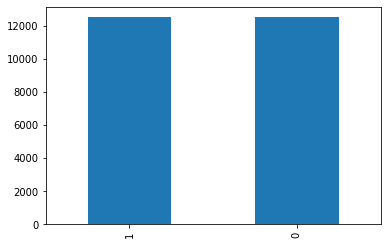

In [16]:
df.category.value_counts().plot.bar()

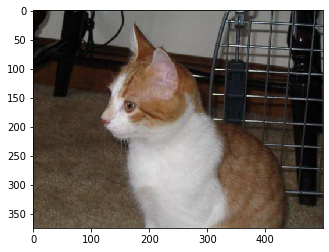

In [20]:
sample = random.choice(trainfiles)

image = load_img('C:\\Users\\student\\Desktop\\dataset\\python\\dogcat\\train\\'+sample)

plt.imshow(image)

In [40]:
## 배치 정규화(batch normalization) : 신경망 입력data를 (평균,분산)=(0,1)로 정규화
from keras.models import Sequential
from keras.layers import *

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(image_width, image_height, image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
es = EarlyStopping(patience=10)
lrreduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.00001, verbose=1)

callbacks =  [es, lrreduction]

In [45]:
# col type을 string으로 변경
df.category = df.category.replace({0:'cat',  1:'dog'})

In [47]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)

In [53]:
train_df = train_df.reset_index(drop=True)

In [54]:
validate_df = validate_df.reset_index(drop=True)

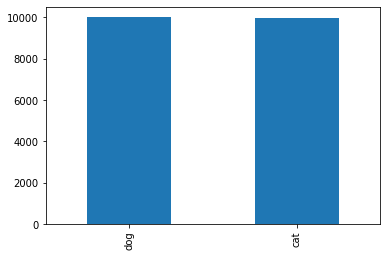

In [56]:
train_df.category.value_counts().plot.bar()

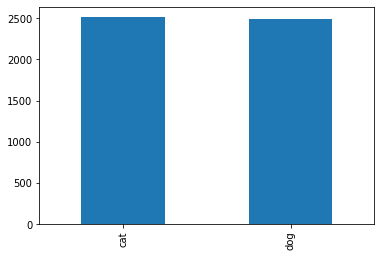

In [57]:
validate_df.category.value_counts().plot.bar()

In [58]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [69]:
# generator 설정
traingen = ImageDataGenerator(rotation_range=15, rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, 
                  width_shift_range=0.1, height_shift_range=0.1)
traingenerator = traingen.flow_from_dataframe(train_df, 'C:\\Users\\student\\Desktop\\dataset\\python\\dogcat\\train\\',
                            x_col='trainfiles', y_col='category', target_size=image_size, class_mode='categorical',
                             batch_size=batch_size)


Found 20000 validated image filenames belonging to 2 classes.


In [70]:
validategen = ImageDataGenerator(rescale=1./255)
validategenerator = validategen.flow_from_dataframe(validate_df, 'C:\\Users\\student\\Desktop\\dataset\\python\\dogcat\\train\\',
                            x_col='trainfiles', y_col='category', target_size=image_size, class_mode='categorical',
                             batch_size=batch_size)

Found 5000 validated image filenames belonging to 2 classes.


In [72]:
example_df = train_df.sample(n=1).reset_index(drop=True)

In [75]:
examplegenerator = traingen.flow_from_dataframe(example_df, 'C:\\Users\\student\\Desktop\\dataset\\python\\dogcat\\train\\',
                            x_col='trainfiles', y_col='category', target_size=image_size, class_mode='categorical')


# example_generator=train_datagen.flow_from_dataframe(
#     example_df,
#     'C:/Users/student/Desktop/train/',
#     x_col='filename',
#     y_col='category',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical'
# )

Found 1 validated image filenames belonging to 1 classes.


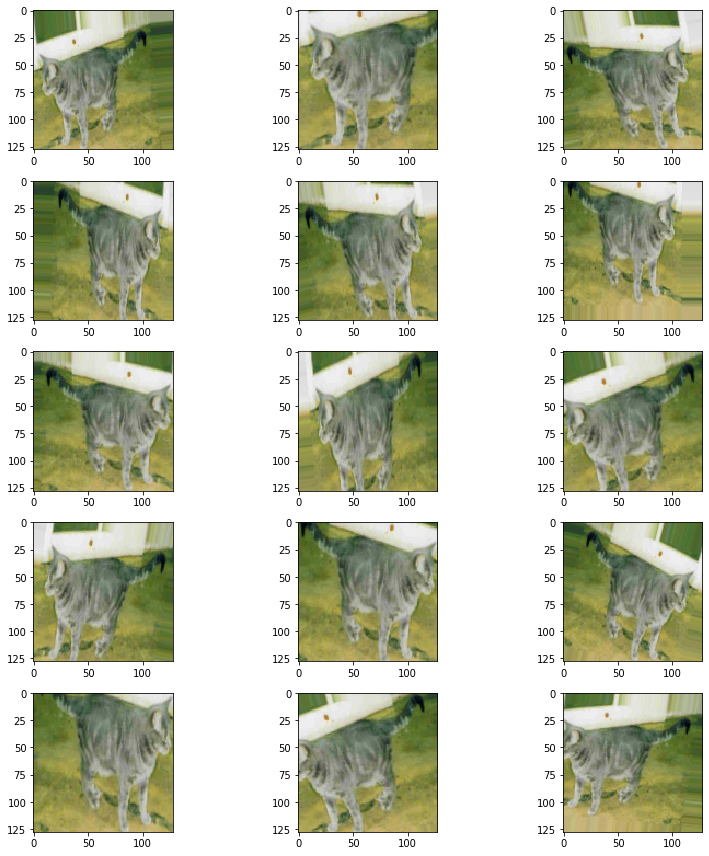

In [76]:
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    
    for xbatch,ybatch in examplegenerator:
        image = xbatch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()      

In [81]:
fast_run = False
epochs = 3

In [82]:
history = model.fit_generator(traingenerator, epochs=epochs, steps_per_epoch=total_train//batch_size,
                             validation_data=validategenerator, validation_steps=total_validate//batch_size,
                             callbacks=callbacks)

Epoch 1/3
1333/1333 [==============================] - 1318s 988ms/step - loss: 0.7090 - accuracy: 0.6078 - val_loss: 0.6154 - val_accuracy: 0.6541
Epoch 2/3
1333/1333 [==============================] - 1253s 940ms/step - loss: 0.6280 - accuracy: 0.6586 - val_loss: 0.7040 - val_accuracy: 0.7013
Epoch 3/3
1333/1333 [==============================] - 1206s 905ms/step - loss: 0.6118 - accuracy: 0.6721 - val_loss: 0.8113 - val_accuracy: 0.6756


In [87]:
# df
path = r'C:\\Users\\student\\Desktop\\dataset\\python\\dogcat'
filenames = os.listdir(path+'\\test')

categories = []
for name in filenames:
    category = name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
testdf = pd.DataFrame({'filenames': filenames, 'category':categories})

testdf.category = testdf.category.replace({0:'cat',  1:'dog'})

In [93]:
total_test = testdf.shape[0]

batch_size = 15


# generator 설정
testgen = ImageDataGenerator(rescale=1./255)
testgenerator = testgen.flow_from_dataframe(testdf, 'C:\\Users\\student\\Desktop\\dataset\\python\\dogcat\\test\\',
                            x_col='filenames', y_col='category', target_size=image_size, class_mode='categorical',
                             batch_size=batch_size)



Found 12500 validated image filenames belonging to 1 classes.


In [94]:
print("-- Predict --")
output = model.predict_generator(testgenerator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(testgenerator.class_indices)
print(output)

-- Predict --
{'cat': 0}
[[0.001 0.999]
 [0.395 0.605]
 [0.652 0.348]
 [0.190 0.810]
 [0.670 0.330]
 [0.011 0.989]
 [0.543 0.457]
 [0.338 0.662]
 [0.201 0.799]
 [0.358 0.642]
 [0.445 0.555]
 [0.049 0.951]
 [0.123 0.877]
 [0.308 0.692]
 [0.624 0.376]
 [0.009 0.991]
 [0.018 0.982]
 [0.150 0.850]
 [0.052 0.948]
 [0.571 0.429]
 [0.016 0.984]
 [0.739 0.261]
 [0.162 0.838]
 [0.256 0.744]
 [0.663 0.337]
 [0.354 0.646]
 [0.033 0.967]
 [0.643 0.357]
 [0.726 0.274]
 [0.062 0.938]
 [0.643 0.357]
 [0.022 0.978]
 [0.447 0.553]
 [0.765 0.235]
 [0.123 0.877]
 [0.180 0.820]
 [0.640 0.360]
 [0.108 0.892]
 [0.611 0.389]
 [0.955 0.045]
 [0.285 0.715]
 [0.927 0.073]
 [0.094 0.906]
 [0.296 0.704]
 [0.502 0.498]
 [0.739 0.261]
 [0.040 0.960]
 [0.013 0.987]
 [0.684 0.316]
 [0.752 0.248]
 [0.115 0.885]
 [0.017 0.983]
 [0.679 0.321]
 [0.747 0.253]
 [0.502 0.498]
 [0.403 0.597]
 [0.090 0.910]
 [0.014 0.986]
 [0.128 0.872]
 [0.389 0.611]
 [0.621 0.379]
 [0.798 0.202]
 [0.479 0.521]
 [0.037 0.963]
 [0.541 0.459]
